In [20]:
from __future__ import print_function

import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
from keras import optimizers
from keras.utils import np_utils

from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

import numpy as np
import pandas as pd
import pickle, datetime

In [21]:
df = pd.read_csv('../Datasets/SST1_dataset/Processed_SST1.tsv', sep='\t')
train_df = pd.read_csv('../Datasets/Kaggle_dataset/train.tsv', sep='\t', header=0)

raw_docs_train      = df[df.split_ind == 1]['Phrases'].values
sentiment_train     = df[df.split_ind == 1]['Label'].values
# raw_docs_train      = train_df['Phrase'].values
# sentiment_train     = train_df['Sentiment'].values
raw_docs_test       = df[df.split_ind == 2]['Phrases'].values
sentiment_test      = df[df.split_ind == 2]['Label'].values
num_labels          = len(np.unique(sentiment_train))

N_TRAIN = len(raw_docs_train)
N_TEST = len(raw_docs_test)

In [22]:
#text pre-processing
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])
stemmer = SnowballStemmer('english')

print ("pre-processing train docs...")
processed_docs_train = []
for doc in raw_docs_train:
   tokens = word_tokenize(doc)
   filtered = [word for word in tokens if word not in stop_words]
   stemmed = [stemmer.stem(word) for word in filtered]
   processed_docs_train.append(stemmed)

print ("pre-processing test docs...")
processed_docs_test = []
for doc in raw_docs_test:
   tokens = word_tokenize(doc)
   filtered = [word for word in tokens if word not in stop_words]
   stemmed = [stemmer.stem(word) for word in filtered]
   processed_docs_test.append(stemmed)
    
processed_docs_all = np.concatenate((processed_docs_train, processed_docs_test), axis=0)

dictionary = corpora.Dictionary(processed_docs_all)
dictionary_size = len(dictionary.keys())

print ("converting to token ids...")
word_id_train, word_id_len = [], []
for doc in processed_docs_train:
    word_ids = [dictionary.token2id[word] for word in doc]
    word_id_train.append(word_ids)
    word_id_len.append(len(word_ids))

word_id_test, word_ids = [], []
for doc in processed_docs_test:
    word_ids = [dictionary.token2id[word] for word in doc]
    word_id_test.append(word_ids)
    word_id_len.append(len(word_ids))
        
seq_len = np.round((np.mean(word_id_len) + 2*np.std(word_id_len))).astype(int)

#pad sequences
x_train = sequence.pad_sequences(np.array(word_id_train), maxlen=seq_len)
x_test  = sequence.pad_sequences(np.array(word_id_test), maxlen=seq_len)
y_train = np_utils.to_categorical(sentiment_train, num_labels)
y_test  = np_utils.to_categorical(sentiment_test, num_labels)

pre-processing train docs...
pre-processing test docs...
converting to token ids...


In [23]:
batch_size = 32
maxlen = seq_len
dictionary_size = len(dictionary.keys())

In [24]:
print('Build model...')
model = Sequential()
model.add(Embedding(dictionary_size, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_labels, activation='softmax'))

# try using different optimizers and different optimizer configs
model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         1766528   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 1,898,757.0
Trainable params: 1,898,757
Non-trainable params: 0.0
_________________________________________________________________


In [29]:
from sklearn.metrics import roc_auc_score
import time
import pylab as pl
from IPython import display
pl.style.use('ggplot')
%matplotlib inline

class Histories(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.acc = []
        self.loss = []
        self.val_loss = []
        self.val_acc = []

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        self.acc.append(logs['acc'])
        self.loss.append(logs['loss'])
        self.val_acc.append(logs['val_acc'])
        self.val_loss.append(logs['val_loss'])
        
        pl.hold(True)
        pl.plot(self.acc, 'r')
        pl.plot(self.loss, 'g')
        pl.plot(self.val_acc, 'b')
        pl.plot(self.val_loss, 'k')
        pl.legend(['Train acc','Train loss','Valid acc', 'Valid loss'], loc=2)
        display.clear_output(wait=True)
        display.display(pl.gcf())
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

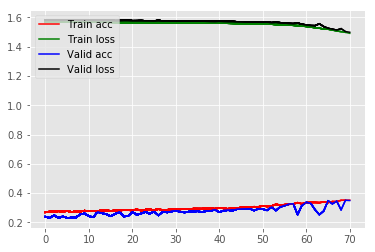

12s - loss: 1.4908 - acc: 0.3527 - val_loss: 1.4982 - val_acc: 0.3493
Epoch 72/200


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(),
              metrics=['accuracy'])

histories = Histories()
res = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=200,
          validation_data=(x_test, y_test), verbose=2, callbacks=[histories])

In [ ]:
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size)

print('Test score:', score)
print('Test accuracy:', acc)

In [35]:

date = str(datetime.date.today() )
time = str(datetime.datetime.now().time())[:-7]

filename = './lstm1_' + '_' + date + '_' +time;
with open( filename, 'wb') as output:
    pickle.dump([res.model.get_config(), res.model.get_weights(), res.history], output, pickle.HIGHEST_PROTOCOL)
    

In [40]:
train_loss = [1.4223, 1.4112, 1.4105, 1.4039, 1.3943, 1.3897, 1.3852, 1.3769, 1.3618, 1.3530, 1.3558, 1.3452, 1.3363, 1.3299, 1.3241, 1.3087, 1.2970, 1.2945, 1.2873, 1.2816, 1.2714, 1.2577, 1.2571, 1.2433, 1.2399, 1.2387, 1.2172, 1.2115, 1.2086, 1.1871, 1.1882, 1.1820, 1.1774, 1.1582, 1.1602, 1.1452, 1.1404, 1.1255, 1.1200, 1.1190, 1.1042, 1.1172, 1.0941, 1.0888, 1.0743, 1.0671, 1.0605, 1.0514, 1.0466, 1.0426, 1.0439, 1.0223, 1.0273, 1.0154, 1.0097, 1.0013, 1.0026, 0.9801, 0.9875, 0.9854, 0.9744, 0.9564, 0.9588, 0.9592, 0.9485, 0.9385, 0.9351, 0.9352, 0.9356, 0.9179, 0.9087, 0.9191, 0.9316, 0.8896, 0.8929, 0.8910, 0.8815, 0.8694, 0.8721, 0.8561, 0.8564, 0.8499, 0.8356, 0.8335, 0.8246, 0.8385, 0.8177, 0.8358, 0.8171, 0.8000, 0.8085, 0.8039, 0.7829, 0.7890, 0.7842, 0.7661, 0.7644, 0.7609, 0.7570, 0.7511, 0.7684, 0.7431, 0.7370, 0.7491, 0.7364, 0.7296, 0.7279, 0.7000, 0.7286, 0.7029, 0.7006, 0.6914, 0.6951, 0.6761, 0.6824, 0.6749, 0.6810, 0.6669, 0.6577, 0.6679, 0.6530, 0.6485, 0.6384, 0.6365, 0.6392, 0.6237, 0.6113, 0.6132, 0.6077, 0.6010, 0.6056, 0.6001, 0.5842, 0.5867, 0.5989, 0.5615, 0.5596, 0.5830, 0.5626, 0.5279, 0.5618, 0.5547, 0.5350, 0.5289, 0.5091, 0.5427, 0.4985, 0.5177, 0.5191, 0.4795, 0.4921, 0.4922, 0.4835, 0.4836, 0.4841, 0.4824, 0.4503, 0.4747, 0.4421, 0.4431, 0.4642, 0.4356, 0.4203, 0.4317, 0.4419, 0.4253, 0.4277, 0.4207, 0.3796, 0.3960, 0.3859, 0.3967, 0.3740, 0.3759, 0.3981, 0.3665, 0.3670, 0.3448, 0.3763, 0.3634, 0.3119, 0.3582, 0.3365, 0.3195, 0.3146, 0.3051, 0.3299, 0.3331, 0.3305, 0.3272, 0.3203, 0.2799, 0.2832, 0.2848, 0.2773, 0.3023, 0.2920, 0.2644, 0.2627, 0.2660, 0.2505, 0.2747, 0.2490, 0.2487, 0.2403, 0.2498, 0.2170, 0.2305, 0.2389, 0.2321, 0.2222, 0.2330, 0.2362, 0.2021, 0.2340, 0.1993, 0.2055, 0.1825, 0.1933, 0.2026, 0.1911, 0.1861, 0.1938, 0.2176, 0.1903, 0.1919, 0.1721, 0.1793, 0.1580, 0.1694, 0.1588, 0.1849, 0.1492, 0.1675, 0.1480, 0.1621, 0.1410, 0.1473, 0.1331, 0.1776, 0.1571, 0.1488, 0.1407, 0.1349, 0.1355, 0.1530, 0.1608, 0.1320, 0.1203, 0.1175, 0.1149, 0.1415, 0.1336, 0.1302, 0.1246, 0.1107, 0.1446, 0.1155, 0.0938, 0.1238, 0.1246, 0.1052, 0.1443, 0.0917, 0.1116, 0.0879, 0.0781, 0.1026, 0.1000, 0.1017, 0.1074, 0.0858, 0.0912, 0.0834, 0.0812, 0.0809, 0.0799, 0.0984, 0.0812, 0.0822, 0.0795, 0.0965, 0.0727, 0.0901, 0.0981, 0.0708, 0.0683, 0.0664, 0.0621, 0.0887, 0.0814, 0.0784, 0.0737, 0.0765, 0.0777, 0.0630, 0.0898, 0.0679, 0.0614, 0.0594, 0.0664, 0.0699, 0.0693, 0.0734, 0.0706, 0.0652, 0.0713, 0.0707, 0.0649, 0.0584, 0.0532, 0.0568, 0.0775, 0.0805, 0.0553, 0.0492, 0.0790, 0.0606, 0.0587, 0.0588, 0.0508, 0.0415, 0.0438, 0.0760, 0.0430, 0.0435, 0.0454, 0.0512, 0.1283, 0.0473, 0.0424, 0.0442, 0.0436, 0.0535, 0.0357, 0.0779, 0.0458, 0.0411, 0.0863, 0.0644, 0.0421, 0.0418, 0.0337, 0.0389, 0.0394, 0.0455, 0.0400, 0.0391, 0.0371, 0.0294, 0.0472, 0.0335, 0.0326, 0.0440, 0.0319, 0.0314, 0.0749, 0.0354, 0.0317, 0.0403, 0.0724, 0.0308, 0.0430, 0.0334, 0.0290, 0.0348, 0.0279, 0.0302, 0.0339, 0.0275, 0.0251, 0.0321, 0.0437, 0.0316, 0.0269, 0.0285, 0.0326, 0.0239, 0.0314, 0.0313, 0.0204, 0.0408, 0.0219, 0.0221, 0.0293, 0.0253, 0.0286, 0.0231, 0.0326, 0.0261, 0.0199, 0.0345, 0.0253, 0.0520, 0.0398, 0.0347, 0.0290, 0.0306, 0.0400, 0.0297, 0.0262, 0.0238, 0.0460, 0.0330, 0.0203, 0.0224, 0.0273, 0.0190, 0.0252, 0.0225, 0.0187, 0.0197, 0.0222, 0.0183, 0.0166, 0.0175, 0.0274, 0.0181, 0.0208, 0.0272, 0.0299, 0.0184, 0.0144, 0.0169, 0.0169, 0.0390, 0.0268, 0.0327, 0.0347, 0.0202, 0.0152, 0.0142, 0.0247, 0.0370, 0.0203, 0.0233, 0.0218, 0.0239, 0.0277, 0.0225, 0.0200, 0.0203, 0.0175, 0.0176, 0.0150, 0.0160, 0.0127, 0.0282, 0.0163, 0.0268, 0.0178, 0.0191, 0.0237, 0.0181, 0.0136, 0.0112, 0.0285, 0.0149, 0.0151, 0.0126, 0.0184, 0.0408, 0.0103, 0.0150, 0.0182, 0.0125, 0.0525, 0.0370, 0.0227, 0.0159, 0.0142, 0.0118, 0.0344, 0.0158, 0.0160, 0.0104, 0.0094, 0.0535, 0.0206, 0.0152, 0.0172, 0.0140, 0.0118, 0.0094, 0.0109, 0.0147, 0.0121, 0.0124, 0.0168, 0.0130, 0.0141, 0.0262, 0.0745, 0.0262, 0.0239, 0.0136, 0.0124, 0.0118, 0.0106, 0.0116, 0.0262, 0.0182, 0.0353, 0.1246, 0.0201, 0.0344, 0.0207, 0.0127, 0.0149, 0.0156, 0.0188, 0.0130, 0.0180, 0.0181, 0.0118, 0.0159, 0.0141, 0.0116, 0.0153, 0.0108, 0.0114, 0.0080, 0.0142, 0.0091, 0.0075, 0.0072, 0.0089, 0.0073, 0.0168, 0.0103, 0.0083, 0.0060, 0.0068, 0.0100, 0.0086, 0.0083, 0.0203, 0.0192, 0.0120, 0.0100, 0.0096, 0.0190, 0.0112, 0.0123, 0.0564, 0.0150, 0.0123, 0.0091, 0.0211, 0.0085, 0.0093, 0.0071, 0.0249, 0.0146, 0.0097, 0.0124, 0.0101, 0.0062, 0.0059, 0.0077, 0.0071, 0.0059, 0.0060, 0.0060, 0.0054, 0.0054, 0.0058, 0.0054, 0.0082, 0.0074, 0.0067, 0.0072, 0.0083, 0.0145, 0.0106, 0.0165, 0.0121, 0.0076, 0.0069, 0.0070, 0.0075, 0.0058, 0.0104, 0.0129, 0.0075, 0.0215, 0.0110, 0.0078, 0.0129, 0.0095, 0.0150, 0.0086, 0.0140, 0.0100, 0.0079, 0.0133, 0.0084, 0.0092, 0.0064, 0.0058, 0.0080, 0.0184, 0.0075, 0.0086, 0.0086, 0.0076, 0.0072, 0.0072, 0.0217, 0.0087, 0.0054, 0.0076, 0.0068, 0.0082, 0.0281, 0.0094, 0.0156, 0.0090, 0.0053, 0.0153, 0.0187, 0.0105, 0.0107, 0.0098, 0.0099, 0.0123, 0.0101, 0.0071, 0.0060, 0.0068, 0.0085, 0.0401, 0.0545, 0.0133, 0.0109, 0.0100, 0.0080, 0.0088, 0.0093, 0.0063, 0.0090, 0.0049, 0.0058, 0.0072, 0.0113, 0.0086, 0.0072, 0.0087, 0.0081, 0.0074, 0.0070, 0.0062, 0.0053, 0.0077, 0.0068, 0.0103, 0.0098, 0.0079, 0.0100, 0.0074, 0.0061, 0.0050, 0.0064, 0.0034, 0.0048, 0.0071, 0.0061, 0.0049, 0.0082, 0.0054, 0.0032, 0.0069, 0.0078, 0.0224, 0.0407, 0.0144, 0.0133, 0.0301, 0.0093, 0.0069, 0.0069, 0.0065, 0.0072, 0.0080, 0.0043, 0.0046, 0.0046, 0.0032, 0.0061, 0.0037, 0.0058, 0.0035, 0.0042, 0.0107, 0.0054, 0.0079, 0.0102, 0.0089, 0.0160, 0.0153, 0.0082, 0.0046, 0.0038, 0.0240, 0.0061, 0.0066, 0.0046, 0.0055, 0.0153, 0.0095, 0.0068, 0.0169, 0.0069, 0.0050, 0.0044, 0.0039, 0.0035, 0.0061, 0.0052, 0.0042, 0.0039, 0.0047, 0.0035, 0.0022, 0.0045, 0.0041, 0.0068, 0.0039, 0.0036, 0.0025, 0.0051, 0.0041, 0.0037, 0.0027, 0.0022, 0.0066, 0.0028, 0.0056, 0.0230, 0.0052, 0.0039, 0.0090, 0.0037, 0.0049, 0.0030, 0.0058, 0.0035, 0.0048, 0.0034, 0.0037, 0.0285, 0.0070, 0.0048, 0.0042, 0.0036, 0.0027, 0.0060, 0.0052, 0.0055, 0.0034, 0.0042, 0.0061, 0.0051, 0.0047, 0.0062, 0.0057, 0.0028, 0.0040, 0.0029, 0.0036, 0.0041, 0.0026, 0.0045, 0.0044, 0.0057, 0.0042, 0.0046, 0.0029, 0.0022, 0.0028, 0.0025, 0.0027, 0.0019, 0.0074, 0.0024, 0.0031, 0.0025, 0.0040, 0.0029, 0.0033, 0.0046, 0.0046, 0.0063, 0.0024, 0.0027, 0.0024, 0.0021, 0.0024, 0.0040, 0.0020, 0.0021, 0.0025, 0.0028, 0.0018, 0.0054, 0.0030, 0.0054, 0.0077, 0.0085, 0.0060, 0.0058, 0.0046, 0.0056, 0.0038, 0.0022, 0.0025, 0.0023, 0.0355, 0.0092, 0.0053, 0.0084, 0.0093, 0.0104, 0.0090, 0.0058, 0.0055, 0.0048, 0.0030, 0.0032, 0.0019, 0.0023, 0.0023, 0.0056, 0.0033, 0.0046, 0.0029, 0.0030, 0.0031, 0.0027, 0.0047, 0.0042, 0.0039, 0.0085, 0.0039, 0.0039, 0.0021, 0.0035, 0.0035, 0.0028, 0.0034, 0.0036, 0.0057, 0.0021, 0.0022, 0.0017, 0.0018, 0.0020, 0.0025, 0.0084, 0.0042, 0.0054, 0.0275]
train_acc = [0.3806, 0.3896, 0.3968, 0.3976, 0.3982, 0.4012, 0.4023, 0.4104, 0.4131, 0.4188, 0.4139, 0.4187, 0.4217, 0.4321, 0.4299, 0.4335, 0.4412, 0.4393, 0.4412, 0.4440, 0.4497, 0.4526, 0.4546, 0.4605, 0.4604, 0.4610, 0.4731, 0.4712, 0.4709, 0.4847, 0.4797, 0.4830, 0.4790, 0.4984, 0.4922, 0.4982, 0.5005, 0.5102, 0.5094, 0.5081, 0.5207, 0.5106, 0.5220, 0.5217, 0.5326, 0.5304, 0.5354, 0.5401, 0.5385, 0.5416, 0.5416, 0.5513, 0.5531, 0.5493, 0.5568, 0.5596, 0.5555, 0.5631, 0.5663, 0.5669, 0.5692, 0.5726, 0.5784, 0.5791, 0.5862, 0.5879, 0.5911, 0.5920, 0.5943, 0.5998, 0.6051, 0.5995, 0.5923, 0.6094, 0.6125, 0.6164, 0.6134, 0.6229, 0.6218, 0.6308, 0.6212, 0.6294, 0.6440, 0.6377, 0.6448, 0.6368, 0.6469, 0.6404, 0.6476, 0.6580, 0.6557, 0.6535, 0.6659, 0.6594, 0.6612, 0.6711, 0.6736, 0.6763, 0.6772, 0.6830, 0.6709, 0.6830, 0.6873, 0.6853, 0.6885, 0.6934, 0.6936, 0.7053, 0.6906, 0.7013, 0.7052, 0.7081, 0.7072, 0.7181, 0.7053, 0.7212, 0.7129, 0.7168, 0.7249, 0.7190, 0.7300, 0.7322, 0.7333, 0.7370, 0.7408, 0.7396, 0.7516, 0.7484, 0.7499, 0.7522, 0.7496, 0.7516, 0.7664, 0.7611, 0.7538, 0.7743, 0.7718, 0.7664, 0.7725, 0.7852, 0.7726, 0.7745, 0.7843, 0.7892, 0.8008, 0.7874, 0.8066, 0.7997, 0.7941, 0.8121, 0.8077, 0.8089, 0.8114, 0.8119, 0.8085, 0.8141, 0.8222, 0.8175, 0.8317, 0.8303, 0.8258, 0.8335, 0.8416, 0.8360, 0.8353, 0.8366, 0.8384, 0.8418, 0.8619, 0.8554, 0.8554, 0.8523, 0.8583, 0.8646, 0.8545, 0.8632, 0.8657, 0.8762, 0.8610, 0.8677, 0.8879, 0.8683, 0.8769, 0.8820, 0.8907, 0.8948, 0.8839, 0.8798, 0.8854, 0.8813, 0.8838, 0.9024, 0.9039, 0.9026, 0.9054, 0.8945, 0.8961, 0.9091, 0.9098, 0.9086, 0.9133, 0.9041, 0.9159, 0.9149, 0.9160, 0.9168, 0.9237, 0.9222, 0.9179, 0.9196, 0.9213, 0.9228, 0.9191, 0.9340, 0.9217, 0.9333, 0.9312, 0.9399, 0.9359, 0.9317, 0.9375, 0.9377, 0.9378, 0.9313, 0.9371, 0.9364, 0.9445, 0.9386, 0.9481, 0.9435, 0.9476, 0.9398, 0.9536, 0.9460, 0.9524, 0.9461, 0.9565, 0.9498, 0.9571, 0.9466, 0.9484, 0.9515, 0.9541, 0.9565, 0.9576, 0.9503, 0.9468, 0.9568, 0.9604, 0.9616, 0.9630, 0.9553, 0.9600, 0.9565, 0.9599, 0.9649, 0.9548, 0.9628, 0.9703, 0.9601, 0.9624, 0.9681, 0.9575, 0.9710, 0.9631, 0.9733, 0.9750, 0.9647, 0.9692, 0.9671, 0.9641, 0.9730, 0.9712, 0.9740, 0.9759, 0.9739, 0.9764, 0.9717, 0.9755, 0.9749, 0.9755, 0.9711, 0.9783, 0.9747, 0.9683, 0.9781, 0.9781, 0.9805, 0.9829, 0.9731, 0.9738, 0.9776, 0.9768, 0.9769, 0.9759, 0.9809, 0.9738, 0.9790, 0.9806, 0.9813, 0.9797, 0.9797, 0.9812, 0.9774, 0.9780, 0.9805, 0.9763, 0.9798, 0.9804, 0.9822, 0.9836, 0.9831, 0.9792, 0.9758, 0.9844, 0.9867, 0.9777, 0.9813, 0.9814, 0.9823, 0.9855, 0.9882, 0.9863, 0.9785, 0.9877, 0.9875, 0.9860, 0.9838, 0.9665, 0.9860, 0.9887, 0.9881, 0.9883, 0.9841, 0.9908, 0.9781, 0.9868, 0.9880, 0.9765, 0.9798, 0.9876, 0.9881, 0.9914, 0.9883, 0.9894, 0.9861, 0.9875, 0.9891, 0.9899, 0.9926, 0.9856, 0.9905, 0.9896, 0.9880, 0.9913, 0.9916, 0.9768, 0.9904, 0.9911, 0.9886, 0.9796, 0.9919, 0.9859, 0.9897, 0.9919, 0.9900, 0.9928, 0.9911, 0.9899, 0.9924, 0.9939, 0.9913, 0.9869, 0.9916, 0.9919, 0.9924, 0.9910, 0.9939, 0.9904, 0.9909, 0.9946, 0.9880, 0.9950, 0.9941, 0.9923, 0.9929, 0.9911, 0.9935, 0.9898, 0.9920, 0.9955, 0.9904, 0.9924, 0.9870, 0.9876, 0.9907, 0.9910, 0.9916, 0.9889, 0.9910, 0.9924, 0.9928, 0.9886, 0.9912, 0.9943, 0.9944, 0.9918, 0.9950, 0.9934, 0.9936, 0.9953, 0.9942, 0.9931, 0.9951, 0.9960, 0.9957, 0.9916, 0.9951, 0.9946, 0.9916, 0.9920, 0.9955, 0.9969, 0.9952, 0.9953, 0.9878, 0.9913, 0.9919, 0.9899, 0.9948, 0.9961, 0.9965, 0.9927, 0.9907, 0.9948, 0.9932, 0.9935, 0.9937, 0.9922, 0.9945, 0.9948, 0.9940, 0.9954, 0.9948, 0.9972, 0.9969, 0.9971, 0.9920, 0.9962, 0.9917, 0.9951, 0.9952, 0.9928, 0.9959, 0.9970, 0.9979, 0.9922, 0.9964, 0.9960, 0.9969, 0.9961, 0.9883, 0.9982, 0.9960, 0.9942, 0.9971, 0.9876, 0.9897, 0.9951, 0.9970, 0.9968, 0.9974, 0.9892, 0.9952, 0.9950, 0.9976, 0.9979, 0.9883, 0.9942, 0.9956, 0.9947, 0.9966, 0.9969, 0.9977, 0.9969, 0.9962, 0.9973, 0.9973, 0.9948, 0.9966, 0.9952, 0.9914, 0.9836, 0.9924, 0.9929, 0.9966, 0.9966, 0.9968, 0.9980, 0.9973, 0.9924, 0.9953, 0.9910, 0.9702, 0.9951, 0.9902, 0.9938, 0.9964, 0.9961, 0.9950, 0.9946, 0.9965, 0.9947, 0.9953, 0.9968, 0.9966, 0.9969, 0.9971, 0.9959, 0.9973, 0.9979, 0.9985, 0.9962, 0.9981, 0.9990, 0.9989, 0.9978, 0.9989, 0.9947, 0.9974, 0.9983, 0.9990, 0.9991, 0.9980, 0.9980, 0.9980, 0.9941, 0.9942, 0.9972, 0.9979, 0.9978, 0.9953, 0.9977, 0.9969, 0.9861, 0.9963, 0.9968, 0.9981, 0.9944, 0.9984, 0.9979, 0.9985, 0.9931, 0.9959, 0.9974, 0.9973, 0.9972, 0.9993, 0.9992, 0.9982, 0.9984, 0.9992, 0.9991, 0.9989, 0.9992, 0.9989, 0.9990, 0.9992, 0.9980, 0.9985, 0.9990, 0.9988, 0.9983, 0.9967, 0.9969, 0.9965, 0.9970, 0.9985, 0.9989, 0.9985, 0.9982, 0.9988, 0.9972, 0.9966, 0.9985, 0.9934, 0.9966, 0.9981, 0.9964, 0.9975, 0.9956, 0.9982, 0.9965, 0.9977, 0.9982, 0.9963, 0.9982, 0.9980, 0.9985, 0.9985, 0.9982, 0.9946, 0.9984, 0.9978, 0.9980, 0.9984, 0.9985, 0.9987, 0.9934, 0.9979, 0.9991, 0.9979, 0.9984, 0.9978, 0.9934, 0.9975, 0.9956, 0.9977, 0.9991, 0.9957, 0.9945, 0.9968, 0.9966, 0.9969, 0.9976, 0.9969, 0.9973, 0.9985, 0.9990, 0.9985, 0.9982, 0.9909, 0.9867, 0.9969, 0.9979, 0.9968, 0.9979, 0.9983, 0.9972, 0.9989, 0.9972, 0.9992, 0.9988, 0.9982, 0.9972, 0.9969, 0.9985, 0.9977, 0.9982, 0.9985, 0.9983, 0.9988, 0.9991, 0.9983, 0.9988, 0.9969, 0.9973, 0.9978, 0.9973, 0.9981, 0.9984, 0.9988, 0.9985, 0.9997, 0.9991, 0.9979, 0.9984, 0.9988, 0.9972, 0.9989, 0.9995, 0.9985, 0.9985, 0.9939, 0.9924, 0.9956, 0.9975, 0.9922, 0.9977, 0.9989, 0.9987, 0.9985, 0.9983, 0.9982, 0.9994, 0.9992, 0.9992, 0.9994, 0.9985, 0.9995, 0.9987, 0.9994, 0.9990, 0.9968, 0.9990, 0.9981, 0.9974, 0.9975, 0.9951, 0.9960, 0.9984, 0.9989, 0.9996, 0.9929, 0.9984, 0.9982, 0.9991, 0.9990, 0.9957, 0.9978, 0.9985, 0.9954, 0.9980, 0.9994, 0.9993, 0.9994, 0.9997, 0.9983, 0.9987, 0.9996, 0.9993, 0.9992, 0.9994, 1.0000, 0.9992, 0.9993, 0.9984, 0.9994, 0.9996, 0.9999, 0.9989, 0.9993, 0.9993, 0.9998, 0.9998, 0.9978, 0.9998, 0.9990, 0.9953, 0.9988, 0.9993, 0.9978, 0.9993, 0.9990, 0.9997, 0.9983, 0.9997, 0.9992, 0.9995, 0.9992, 0.9946, 0.9982, 0.9993, 0.9992, 0.9995, 0.9998, 0.9988, 0.9989, 0.9991, 0.9995, 0.9991, 0.9984, 0.9990, 0.9988, 0.9989, 0.9985, 0.9997, 0.9993, 0.9997, 0.9994, 0.9991, 0.9997, 0.9992, 0.9989, 0.9985, 0.9992, 0.9991, 0.9993, 0.9998, 0.9997, 0.9998, 0.9998, 1.0000, 0.9984, 0.9997, 0.9994, 0.9997, 0.9987, 0.9994, 0.9993, 0.9988, 0.9990, 0.9989, 0.9998, 0.9997, 0.9997, 0.9998, 0.9995, 0.9991, 0.9999, 0.9998, 0.9996, 0.9999, 0.9999, 0.9984, 0.9995, 0.9984, 0.9983, 0.9975, 0.9987, 0.9989, 0.9985, 0.9988, 0.9993, 0.9999, 0.9996, 0.9997, 0.9907, 0.9976, 0.9985, 0.9977, 0.9973, 0.9974, 0.9968, 0.9988, 0.9985, 0.9989, 0.9997, 0.9994, 0.9999, 0.9999, 0.9996, 0.9983, 0.9996, 0.9988, 0.9995, 0.9995, 0.9994, 0.9997, 0.9988, 0.9992, 0.9988, 0.9977, 0.9992, 0.9987, 0.9998, 0.9989, 0.9993, 0.9996, 0.9995, 0.9991, 0.9982, 0.9997, 0.9997, 0.9999, 0.9999, 0.9998, 0.9997, 0.9976, 0.9992, 0.9989, 0.9938]
val_loss = [1.4880, 1.4540, 1.4822, 1.4394, 1.4993, 1.4640, 1.4325, 1.4407, 1.4598, 1.4777, 1.4338, 1.4466, 1.5117, 1.4710, 1.4828, 1.4102, 1.4302, 1.4467, 1.4485, 1.4405, 1.4121, 1.4032, 1.4487, 1.5846, 1.5742, 1.4372, 1.4128, 1.4008, 1.3890, 1.4512, 1.3820, 1.4281, 1.5703, 1.4362, 1.4020, 1.4671, 1.4099, 1.3958, 1.4801, 1.4414, 1.4676, 1.4199, 1.5302, 1.4275, 1.4757, 1.4608, 1.6525, 1.4531, 1.4351, 1.4544, 1.5356, 1.4599, 1.5009, 1.5929, 1.5088, 1.5071, 1.7755, 1.6931, 1.7249, 1.5241, 1.6785, 1.5580, 1.5225, 1.5522, 1.8058, 1.9767, 1.7092, 1.6648, 1.5501, 1.7138, 1.6084, 1.6570, 1.6637, 1.6002, 1.6210, 1.7074, 1.6310, 1.6782, 1.7945, 1.6575, 1.8069, 1.6478, 1.6785, 1.6911, 1.7867, 1.8078, 1.6880, 1.6737, 1.7307, 2.4150, 1.8099, 2.7104, 1.7930, 1.7659, 2.1618, 1.7562, 1.8484, 1.8813, 1.8004, 1.9228, 1.8535, 1.9061, 1.9164, 2.0134, 1.8899, 1.9357, 1.9355, 1.9206, 1.9595, 1.9290, 2.0575, 2.1423, 1.9548, 2.0191, 2.0320, 1.9619, 2.2984, 2.2792, 2.4012, 2.0949, 2.0745, 2.0339, 2.0258, 2.2750, 2.0277, 2.5328, 2.1656, 2.1531, 2.1998, 2.0911, 2.3655, 2.1825, 2.3108, 2.4899, 2.1380, 2.2662, 2.1985, 2.3516, 2.9331, 4.6544, 2.1923, 2.2384, 2.2283, 2.2826, 2.3836, 2.3061, 2.3585, 2.2517, 2.7994, 2.2860, 2.3340, 2.3418, 2.4063, 2.6169, 2.5414, 2.4547, 2.4046, 2.3812, 2.5828, 2.4777, 2.4238, 2.5850, 3.1556, 2.5103, 2.5799, 2.6006, 2.5333, 2.5370, 3.3661, 2.7913, 2.7402, 2.6333, 2.9840, 2.6862, 2.6553, 2.8075, 2.7832, 2.7483, 2.9469, 2.7059, 2.7803, 3.6854, 2.8656, 2.7172, 3.1382, 2.8217, 2.8752, 2.7736, 2.9204, 2.8073, 3.1210, 2.9165, 2.9496, 3.2607, 3.0011, 3.0382, 2.9105, 2.9014, 3.0203, 3.0444, 3.4001, 2.9213, 2.9690, 3.0520, 3.1185, 3.0755, 3.2098, 3.1661, 3.3810, 3.1625, 3.3815, 3.3929, 3.1942, 3.2533, 3.2190, 3.1626, 3.1981, 3.3705, 3.2083, 3.3004, 3.4267, 3.3143, 3.4106, 3.3740, 3.2144, 3.2776, 3.5613, 3.4403, 3.5314, 3.4182, 3.4833, 3.5194, 3.5351, 3.5450, 3.5392, 3.5469, 3.6354, 3.6665, 3.5639, 3.6243, 3.5736, 3.6564, 3.7180, 3.6284, 3.6099, 3.6430, 3.8118, 3.6779, 3.6383, 3.6993, 3.8812, 3.9360, 3.7673, 3.8480, 3.7244, 3.8439, 4.0451, 3.7981, 3.9466, 4.0176, 3.9780, 3.8861, 3.7543, 3.8861, 4.0060, 4.0112, 4.1969, 4.0945, 4.0382, 4.1392, 4.0684, 4.0355, 4.2343, 4.1117, 4.0852, 4.1365, 4.0435, 4.3319, 4.0561, 4.0759, 4.2551, 4.0749, 4.2359, 3.9621, 4.2383, 4.2706, 4.2336, 4.2220, 4.4606, 4.2623, 4.2056, 4.3093, 4.2766, 4.2380, 4.3106, 4.3583, 4.2174, 4.3582, 4.4006, 4.4160, 4.4791, 4.2535, 4.4247, 4.2579, 4.3401, 4.3721, 4.4307, 4.3281, 4.3139, 4.4701, 4.4515, 6.1729, 4.6201, 4.5019, 4.3574, 4.3844, 4.3035, 4.4707, 4.4719, 4.5184, 4.5268, 4.4275, 4.5999, 4.5176, 4.5345, 4.5506, 4.5640, 4.6461, 4.2535, 4.4740, 4.5640, 4.5813, 4.7297, 4.8142, 4.6383, 4.8168, 4.5652, 4.7698, 4.6254, 4.5654, 4.7076, 4.5488, 4.6115, 4.6551, 4.6741, 4.9576, 4.7267, 4.7986, 4.7434, 4.7088, 4.8023, 4.7409, 4.7055, 4.7384, 4.7677, 5.3280, 4.6347, 4.7768, 4.7872, 4.7816, 4.6882, 4.6791, 4.7701, 4.7748, 5.1302, 4.8936, 4.8427, 4.7591, 4.8518, 4.8905, 4.9291, 4.8083, 5.0088, 4.9368, 4.9114, 4.9427, 4.9197, 4.9509, 5.1986, 4.9907, 5.0126, 5.0555, 5.0943, 4.9709, 4.9292, 5.0319, 4.9991, 5.1077, 5.0131, 5.1434, 5.0277, 5.0575, 5.1383, 5.1304, 5.0963, 5.0560, 5.0618, 5.0461, 5.1926, 5.0443, 5.0329, 5.1115, 5.0076, 5.0041, 5.1519, 5.2507, 5.0495, 5.2744, 5.1660, 5.1288, 5.1274, 5.1695, 5.0150, 5.1156, 5.1611, 5.2744, 5.0910, 5.1923, 5.1582, 5.4070, 5.1922, 5.1931, 5.2199, 5.3439, 5.2831, 5.1592, 5.1605, 5.0108, 5.1109, 5.2088, 5.1019, 5.1725, 5.2481, 5.1974, 5.1239, 5.1632, 5.2952, 5.1615, 5.1567, 5.2564, 5.3236, 5.1472, 5.2063, 5.2971, 5.2587, 5.2719, 5.3366, 5.2595, 5.2769, 5.1818, 5.3073, 5.2249, 5.2394, 5.2070, 5.2674, 5.4310, 5.2069, 5.3529, 5.3339, 5.3044, 5.7026, 5.1850, 5.4031, 5.3559, 5.2941, 5.3350, 5.1019, 5.2414, 5.2461, 5.2968, 5.4101, 6.2118, 5.4009, 5.3969, 5.3064, 5.3391, 5.3997, 5.4084, 5.2549, 5.2999, 5.3182, 5.3384, 5.4044, 5.4381, 5.3388, 5.3935, 5.5539, 5.3265, 5.3914, 5.4260, 5.4680, 5.3487, 5.4050, 5.3038, 5.4692, 5.4934, 5.4623, 5.5217, 5.4393, 5.4986, 5.4412, 5.3133, 5.2080, 5.1451, 5.2596, 5.4548, 5.2472, 5.2896, 5.3571, 5.4171, 5.4004, 5.3365, 5.2646, 5.2850, 5.3845, 5.4331, 5.3231, 5.4432, 5.4026, 5.3869, 5.4656, 5.4868, 5.3964, 5.3901, 5.4708, 5.4614, 5.5235, 5.4307, 5.4153, 5.5879, 5.5583, 5.5576, 5.6967, 5.5617, 5.4128, 5.6546, 5.5164, 5.4848, 5.6292, 5.6559, 5.5042, 5.5179, 5.5561, 6.0509, 5.5501, 5.5160, 5.5919, 5.3655, 5.4564, 5.5170, 5.6208, 5.5499, 5.4931, 5.5307, 5.5267, 5.5468, 5.5400, 5.5702, 5.5813, 5.6091, 5.5819, 5.6158, 5.5808, 5.6306, 5.6765, 5.6082, 5.5730, 5.6682, 5.6086, 5.6800, 5.6631, 5.6502, 5.6775, 5.6565, 5.6084, 5.6150, 5.5574, 5.6525, 5.6183, 5.6649, 5.6221, 5.6697, 5.8146, 5.7226, 5.6308, 5.6047, 5.6374, 5.6069, 5.6873, 5.6749, 5.6759, 5.7272, 5.6256, 5.6256, 5.6335, 5.6322, 5.7048, 5.7046, 5.7417, 5.7086, 5.7072, 5.5989, 5.7885, 5.7106, 5.7302, 5.6942, 5.6781, 5.5959, 5.5897, 5.7346, 5.6982, 5.7139, 5.7131, 5.7240, 5.7926, 5.7560, 5.6830, 5.7182, 5.7860, 5.8481, 5.6836, 5.7283, 5.8019, 5.7419, 5.7124, 5.6196, 5.6738, 5.7286, 5.7656, 5.7427, 5.8239, 6.0039, 5.5517, 5.6370, 5.6153, 5.6555, 5.6670, 5.7688, 5.7173, 5.7542, 5.7532, 5.7780, 5.7273, 5.6636, 5.7953, 5.7177, 5.6521, 5.7358, 5.7650, 5.8487, 5.7651, 5.7747, 5.7414, 5.8322, 5.6961, 5.7723, 5.7963, 5.7598, 5.6966, 5.7939, 5.7494, 5.7543, 5.8795, 5.7851, 5.8461, 5.7794, 5.7664, 5.7774, 5.9159, 5.8718, 5.9400, 5.7027, 5.8713, 5.9085, 5.7449, 5.6758, 5.7332, 5.7273, 5.7536, 5.7481, 5.8075, 5.8224, 5.7760, 5.8770, 5.8006, 5.7982, 5.8730, 5.8990, 5.8914, 5.9396, 5.8339, 5.8318, 5.9367, 5.8515, 5.8738, 6.0126, 5.8634, 5.8420, 5.8155, 5.8133, 5.8458, 5.8058, 5.9019, 5.7467, 5.8449, 5.8302, 5.8713, 5.8964, 5.7574, 5.9245, 5.8232, 5.8673, 5.8072, 5.9089, 5.8749, 5.8658, 5.9048, 5.9103, 5.8592, 5.8497, 5.9282, 5.9071, 5.9386, 5.9147, 5.8794, 6.0240, 5.9045, 5.9648, 5.9756, 5.9002, 5.8567, 5.9816, 5.9146, 5.9784, 6.0140, 5.9314, 5.9356, 7.0701, 5.9313, 5.8237, 5.9124, 5.8988, 5.9134, 5.9224, 5.9374, 6.0142, 5.9808, 5.9475, 6.0030, 6.0241, 5.8400, 5.9278, 5.9071, 5.8324, 5.9540, 5.9907, 5.9809, 5.9593, 5.9258, 5.9418, 6.0301, 5.9568, 5.8701, 5.9882, 5.9198, 5.9547, 5.9410, 5.9518, 5.9776, 5.9836, 6.0806, 6.0013, 5.8890, 5.9831, 6.0483, 6.1143, 5.9650, 5.9787, 5.9575, 6.0037, 5.9972, 6.0428, 6.0751, 6.0183, 6.0845, 6.0030, 6.0496, 6.0543, 6.0475, 6.0651, 6.0133, 6.0443, 6.0293, 6.0649, 6.0532, 6.0165, 6.0896, 6.0729, 6.0238, 6.1047, 6.0328, 6.1946, 6.0915, 6.1013, 6.1123, 6.0684, 6.0614, 6.0008, 6.1001, 6.0044, 6.0408, 6.0818, 6.0323, 6.1612, 6.1786, 6.0507, 6.1638, 6.0173, 6.0582, 6.0165, 6.0282, 6.0765, 6.2550, 5.9610, 6.0582, 5.9297, 6.0748, 6.0151, 6.0222, 6.0268, 6.0202, 6.0731, 6.0147, 6.0579, 6.0580, 6.0382, 5.9844, 6.0956, 6.1079, 6.1336, 6.0313, 6.1051, 6.1251, 6.0583, 6.1095, 6.0850, 6.0573, 6.1124, 6.0489, 6.1008, 6.0451, 6.1006, 6.1468, 6.1324, 6.1344, 6.1296, 6.1231, 6.1435, 6.1263, 6.1730, 6.1339, 6.1035]
val_acc = [0.3525,0.3588,0.3416,0.3738,0.3538,0.3493,0.3747,0.3733,0.3561,0.3611,0.3683,0.3579,0.3624,0.3462,0.3484,0.3932,0.3769,0.3701,0.3665,0.3814,0.3941,0.3977,0.3869,0.3548,0.3566,0.3950,0.4041,0.4036,0.3995,0.3873,0.4086,0.4014,0.3706,0.4005,0.4032,0.3900,0.3955,0.4086,0.3860,0.4014,0.3900,0.3973,0.3937,0.4054,0.4086,0.3977,0.3796,0.3891,0.4122,0.3873,0.3950,0.4063,0.4077,0.3769,0.3819,0.3964,0.3751,0.3819,0.3552,0.4050,0.3864,0.3855,0.4045,0.4172,0.3502,0.3480,0.3828,0.3937,0.4122,0.3814,0.4109,0.3719,0.3887,0.3792,0.3801,0.3968,0.3977,0.4036,0.3805,0.3914,0.3756,0.3982,0.3955,0.4018,0.3919,0.3683,0.3968,0.4077,0.3846,0.3520,0.3941,0.3335,0.3846,0.3950,0.3710,0.3855,0.3738,0.3842,0.4118,0.4045,0.3579,0.4027,0.3783,0.3643,0.3910,0.3937,0.4045,0.3928,0.3733,0.3787,0.3778,0.3928,0.3873,0.3887,0.3905,0.3765,0.3923,0.3502,0.3548,0.3792,0.3991,0.3882,0.3968,0.3724,0.3905,0.3480,0.3810,0.3910,0.3882,0.3860,0.3701,0.3783,0.3805,0.3584,0.3900,0.3878,0.3833,0.3611,0.3267,0.2937,0.3873,0.3878,0.3742,0.3756,0.3792,0.3814,0.3778,0.3738,0.3584,0.3860,0.3647,0.3765,0.3738,0.3814,0.3643,0.3796,0.3928,0.3828,0.3887,0.3900,0.3828,0.3747,0.3719,0.3765,0.3701,0.3891,0.3828,0.3792,0.3570,0.3534,0.3855,0.3670,0.3584,0.3787,0.3810,0.3837,0.3724,0.3507,0.3620,0.3778,0.3647,0.3253,0.3742,0.3833,0.3701,0.3774,0.3538,0.3502,0.3851,0.3796,0.3810,0.3593,0.3810,0.3543,0.3719,0.3778,0.3919,0.3715,0.3810,0.3851,0.3670,0.3692,0.3769,0.3787,0.3760,0.3860,0.3398,0.3824,0.3683,0.3837,0.3751,0.3801,0.3774,0.3742,0.3747,0.3665,0.3769,0.3679,0.3923,0.3747,0.3706,0.3796,0.3783,0.3566,0.3538,0.3873,0.3715,0.3679,0.3710,0.3873,0.3792,0.3787,0.3534,0.3701,0.3597,0.3719,0.3710,0.3729,0.3566,0.3683,0.3801,0.3719,0.3647,0.3670,0.3652,0.3692,0.3724,0.3756,0.3629,0.3747,0.3570,0.3579,0.3593,0.3805,0.3729,0.3620,0.3724,0.3724,0.3679,0.3624,0.3620,0.3656,0.3643,0.3552,0.3570,0.3692,0.3733,0.3747,0.3661,0.3710,0.3769,0.3643,0.3643,0.3710,0.3796,0.3719,0.3643,0.3647,0.3656,0.3765,0.3692,0.3706,0.3579,0.3566,0.3670,0.3579,0.3643,0.3633,0.3597,0.3643,0.3593,0.3692,0.3624,0.3706,0.3633,0.3570,0.3656,0.3692,0.3588,0.3538,0.3633,0.3588,0.3575,0.3760,0.3525,0.3674,0.3652,0.3624,0.3633,0.3516,0.3566,0.2995,0.3606,0.3692,0.3692,0.3697,0.3629,0.3665,0.3520,0.3516,0.3335,0.3543,0.3557,0.3665,0.3620,0.3525,0.3434,0.3670,0.3670,0.3615,0.3697,0.3670,0.3624,0.3552,0.3629,0.3520,0.3489,0.3575,0.3579,0.3525,0.3548,0.3679,0.3543,0.3557,0.3579,0.3443,0.3620,0.3588,0.3611,0.3566,0.3602,0.3611,0.3638,0.3611,0.3602,0.3398,0.3602,0.3602,0.3538,0.3692,0.3597,0.3710,0.3670,0.3760,0.3548,0.3633,0.3593,0.3756,0.3557,0.3575,0.3647,0.3611,0.3611,0.3670,0.3647,0.3665,0.3647,0.3615,0.3330,0.3624,0.3498,0.3561,0.3620,0.3597,0.3620,0.3498,0.3602,0.3507,0.3624,0.3643,0.3606,0.3602,0.3593,0.3466,0.3638,0.3688,0.3611,0.3584,0.3588,0.3593,0.3498,0.3611,0.3647,0.3620,0.3575,0.3557,0.3701,0.3656,0.3624,0.3606,0.3570,0.3697,0.3647,0.3602,0.3529,0.3511,0.3697,0.3620,0.3557,0.3661,0.3606,0.3602,0.3579,0.3579,0.3570,0.3643,0.3579,0.3538,0.3602,0.3620,0.3674,0.3579,0.3502,0.3615,0.3656,0.3502,0.3529,0.3584,0.3638,0.3665,0.3511,0.3584,0.3638,0.3575,0.3588,0.3597,0.3620,0.3615,0.3579,0.3710,0.3643,0.3538,0.3593,0.3652,0.3611,0.3661,0.3579,0.3588,0.3575,0.3543,0.3385,0.3611,0.3570,0.3548,0.3538,0.3566,0.3443,0.3647,0.3520,0.3656,0.3525,0.3299,0.3452,0.3489,0.3552,0.3561,0.3534,0.3588,0.3552,0.3769,0.3602,0.3561,0.3597,0.3575,0.3557,0.3548,0.3620,0.3665,0.3602,0.3606,0.3561,0.3511,0.3466,0.3452,0.3434,0.3548,0.3548,0.3507,0.3597,0.3611,0.3403,0.3579,0.3493,0.3597,0.3611,0.3457,0.3561,0.3502,0.3538,0.3498,0.3525,0.3434,0.3602,0.3584,0.3597,0.3615,0.3633,0.3543,0.3570,0.3575,0.3593,0.3588,0.3529,0.3511,0.3633,0.3593,0.3511,0.3484,0.3579,0.3629,0.3489,0.3606,0.3552,0.3570,0.3656,0.3701,0.3615,0.3606,0.3448,0.3566,0.3697,0.3611,0.3575,0.3335,0.3679,0.3629,0.3593,0.3661,0.3561,0.3584,0.3566,0.3602,0.3633,0.3480,0.3611,0.3629,0.3615,0.3575,0.3593,0.3543,0.3597,0.3629,0.3643,0.3557,0.3597,0.3575,0.3588,0.3566,0.3561,0.3584,0.3566,0.3579,0.3466,0.3670,0.3665,0.3525,0.3679,0.3597,0.3552,0.3579,0.3629,0.3701,0.3484,0.3602,0.3593,0.3529,0.3575,0.3561,0.3620,0.3529,0.3534,0.3525,0.3620,0.3529,0.3584,0.3588,0.3602,0.3511,0.3507,0.3579,0.3493,0.3538,0.3561,0.3584,0.3548,0.3543,0.3647,0.3525,0.3606,0.3489,0.3593,0.3498,0.3570,0.3502,0.3475,0.3520,0.3520,0.3579,0.3561,0.3538,0.3566,0.3552,0.3588,0.3557,0.3629,0.3656,0.3525,0.3466,0.3579,0.3538,0.3511,0.3597,0.3620,0.3629,0.3543,0.3638,0.3633,0.3615,0.3548,0.3643,0.3529,0.3606,0.3502,0.3561,0.3416,0.3624,0.3579,0.3520,0.3665,0.3629,0.3566,0.3557,0.3584,0.3570,0.3624,0.3597,0.3566,0.3566,0.3552,0.3534,0.3570,0.3525,0.3462,0.3552,0.3538,0.3538,0.3466,0.3552,0.3421,0.3529,0.3507,0.3566,0.3502,0.3584,0.3561,0.3529,0.3353,0.3480,0.3575,0.3557,0.3484,0.3534,0.3462,0.3434,0.3566,0.3525,0.3489,0.3489,0.3489,0.3529,0.3516,0.3529,0.3552,0.3534,0.3511,0.3434,0.3516,0.3557,0.3570,0.3597,0.3534,0.3588,0.3457,0.3656,0.3606,0.3525,0.3507,0.3507,0.3502,0.3502,0.3511,0.3584,0.3538,0.3471,0.3584,0.3552,0.3566,0.3525,0.3566,0.3566,0.3511,0.3534,0.3561,0.3575,0.3538,0.3457,0.3620,0.3529,0.3493,0.3489,0.3543,0.3615,0.3552,0.3534,0.3471,0.3647,0.3548,0.3371,0.3575,0.3534,0.3543,0.3538,0.3493,0.3534,0.3502,0.3484,0.3502,0.3557,0.3538,0.3552,0.3538,0.3457,0.3570,0.3561,0.3534,0.3493,0.3593,0.3552,0.3570,0.3543,0.3394,0.3606,0.3624,0.3543,0.3579,0.3638,0.3543,0.3484,0.3493,0.3511,0.3557,0.3489,0.3570,0.3575,0.3597,0.3593,0.3552,0.3543,0.3543,0.3561,0.3579,0.3579,0.3529,0.3548,0.3606,0.3579,0.3579,0.3633,0.3588,0.3525,0.3584,0.3588,0.3593,0.3543,0.3529,0.3570,0.3471,0.3475,0.3566,0.3538,0.3516,0.3557,0.3534,0.3552,0.3489,0.3548,0.3543,0.3548,0.3448,0.3566,0.3570,0.3493,0.3480,0.3525,0.3480,0.3529,0.3493,0.3507,0.3561,0.3471,0.3425,0.3507,0.3339,0.3507,0.3561,0.3520,0.3543,0.3579,0.3588,0.3525,0.3511,0.3593,0.3538,0.3566,0.3538,0.3602,0.3606,0.3557,0.3516,0.3552,0.3516,0.3502,0.3557,0.3516,0.3561,0.3548,0.3588,0.3471,0.3529,0.3557,0.3552,0.3520,0.3529,0.3511,0.3471,0.3529,0.3471,0.3543,0.3516,0.3602,0.3566,0.3529]

In [41]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(train_acc)
plt.plot(train_loss)
plt.plot(val_acc)
# plt.plot(val_loss)
plt.legend(['Train acc','Train loss','Valid acc', 'Valid loss'], loc=2)
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.title('Using '+ model_type)
date = str(datetime.date.today() )
time = str(datetime.datetime.now().time())[:-7]
imgName = 'Images/' + model_type + '_' + date + '_' + time + '.jpg'
plt.savefig( imgName, dpi= 200, bbox_inches='tight', transparent=False)
plt.show()

NameError: name 'model_type' is not defined